# Base Model - Movement Classification

## Setup

In [ ]:
# import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

## Load the Data

In [ ]:
# convenience function to get the data from .npz file
def get_data(sub):
    """
    Read the data from .npz file and get the data numpy arrays

    Parameters:
    sub (str): String specifying which subset of the data to read

    Return:
    tup (3d numpy array, 1d numpy array): Tuple of two numpy arrays;
            the first containing the features and the second containing labels
    """
    with np.load('/project/data.npz', allow_pickle=True) as data:
        # return specific subset of the data based on the argument
        if sub == 'train':
            return data['X_train'], data['y_train']
        elif sub == 'valid':
            return data['X_valid'], data['y_valid']
        elif sub == 'test':
            return data['X_test'], data['y_test']

In [ ]:
X_train, y_train = get_data('train')
X_valid, y_valid = get_data('valid')
X_test, y_test = get_data('test')

In [ ]:
X_train.shape, y_train.shape

((54764, 13, 100), (54764,))

In [ ]:
# we encode the classes
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [ ]:
def balance_data(features, labels):
    """
    Convenience function to balance the data by resampling with replacement in equal distribution

    Parameters:
    features (3d numpy array): Array including the features
    labels (1d numpy array): Array including the labels

    Return:
    tuple (3d numpy array, 1d numpy array: Same arrays after balancing
    """
    # initialize lists to store the data
    X = []
    Y = []
    # define the set of classes
    classes = np.unique(labels)
    sample_size = len(labels) // 48 * 10
    # loop over the classes
    for c in classes:
        # return the indexes from the labels
        condition = np.where(labels == c)[0]
        # select a sample_size number of samples from each condition providing their index
        idx = np.random.choice(condition, size=sample_size, replace=True)
        # index into the features, and labels arrays
        x = features[idx, :, :]
        y = labels[idx]
        # append to the full dataset
        X.append(x)
        Y.append(y)

    # concatenate the data across the instances
    X_balanced = np.concatenate(X, axis=0)
    Y_balanced = np.concatenate(Y, axis=0)

    # shuffle the data (there's most likely an easier way)
    order = np.arange(len(Y_balanced))
    np.random.shuffle(order)
    X_balanced = X_balanced[order]
    Y_balanced = Y_balanced[order]

    return X_balanced, Y_balanced

In [ ]:
X_train_balanced, y_train_balanced = balance_data(X_train, y_train)

In [ ]:
num_classes = len(np.unique(y_train_balanced))

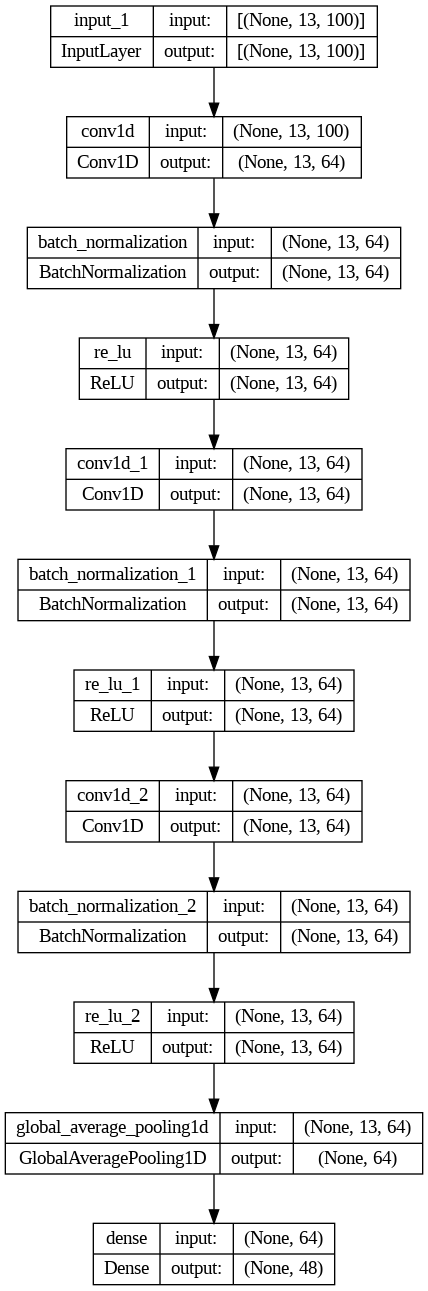

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train_balanced.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy'],
)
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid),
    verbose=1,
)

Epoch 1/100
268/268 [==============================] - 8s 14ms/step - loss: 2.4755 - sparse_categorical_accuracy: 0.3897 - val_loss: 3.4786 - val_sparse_categorical_accuracy: 0.0355 - lr: 0.0010
Epoch 2/100
 13/268 [>.............................] - ETA: 2s - loss: 1.4944 - sparse_categorical_accuracy: 0.6203

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


268/268 [==============================] - 3s 10ms/step - loss: 1.1253 - sparse_categorical_accuracy: 0.7145 - val_loss: 3.3615 - val_sparse_categorical_accuracy: 0.0690 - lr: 0.0010
Epoch 3/100
268/268 [==============================] - 3s 10ms/step - loss: 0.6839 - sparse_categorical_accuracy: 0.8350 - val_loss: 3.2632 - val_sparse_categorical_accuracy: 0.0917 - lr: 0.0010
Epoch 4/100
268/268 [==============================] - 3s 10ms/step - loss: 0.4744 - sparse_categorical_accuracy: 0.8945 - val_loss: 3.1120 - val_sparse_categorical_accuracy: 0.1335 - lr: 0.0010
Epoch 5/100
268/268 [==============================] - 3s 10ms/step - loss: 0.3556 - sparse_categorical_accuracy: 0.9249 - val_loss: 3.1718 - val_sparse_categorical_accuracy: 0.1593 - lr: 0.0010
Epoch 6/100
268/268 [==============================] - 3s 10ms/step - loss: 0.2824 - sparse_categorical_accuracy: 0.9416 - val_loss: 3.2691 - val_sparse_categorical_accuracy: 0.1544 - lr: 0.0010
Epoch 7/100
268/268 [================

In [ ]:
test_loss, test_acc = model.evaluate(X_valid, y_valid)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

415/415 [==============================] - 1s 2ms/step - loss: 4.2009 - sparse_categorical_accuracy: 0.3864
Test accuracy 0.38640308380126953
Test loss 4.200903415679932


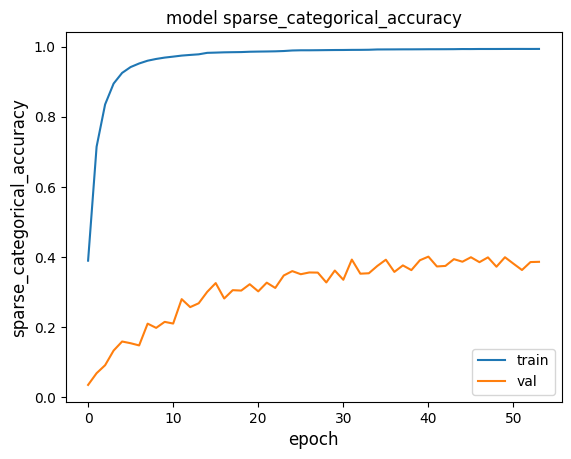

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

415/415 [==============================] - 1s 2ms/step


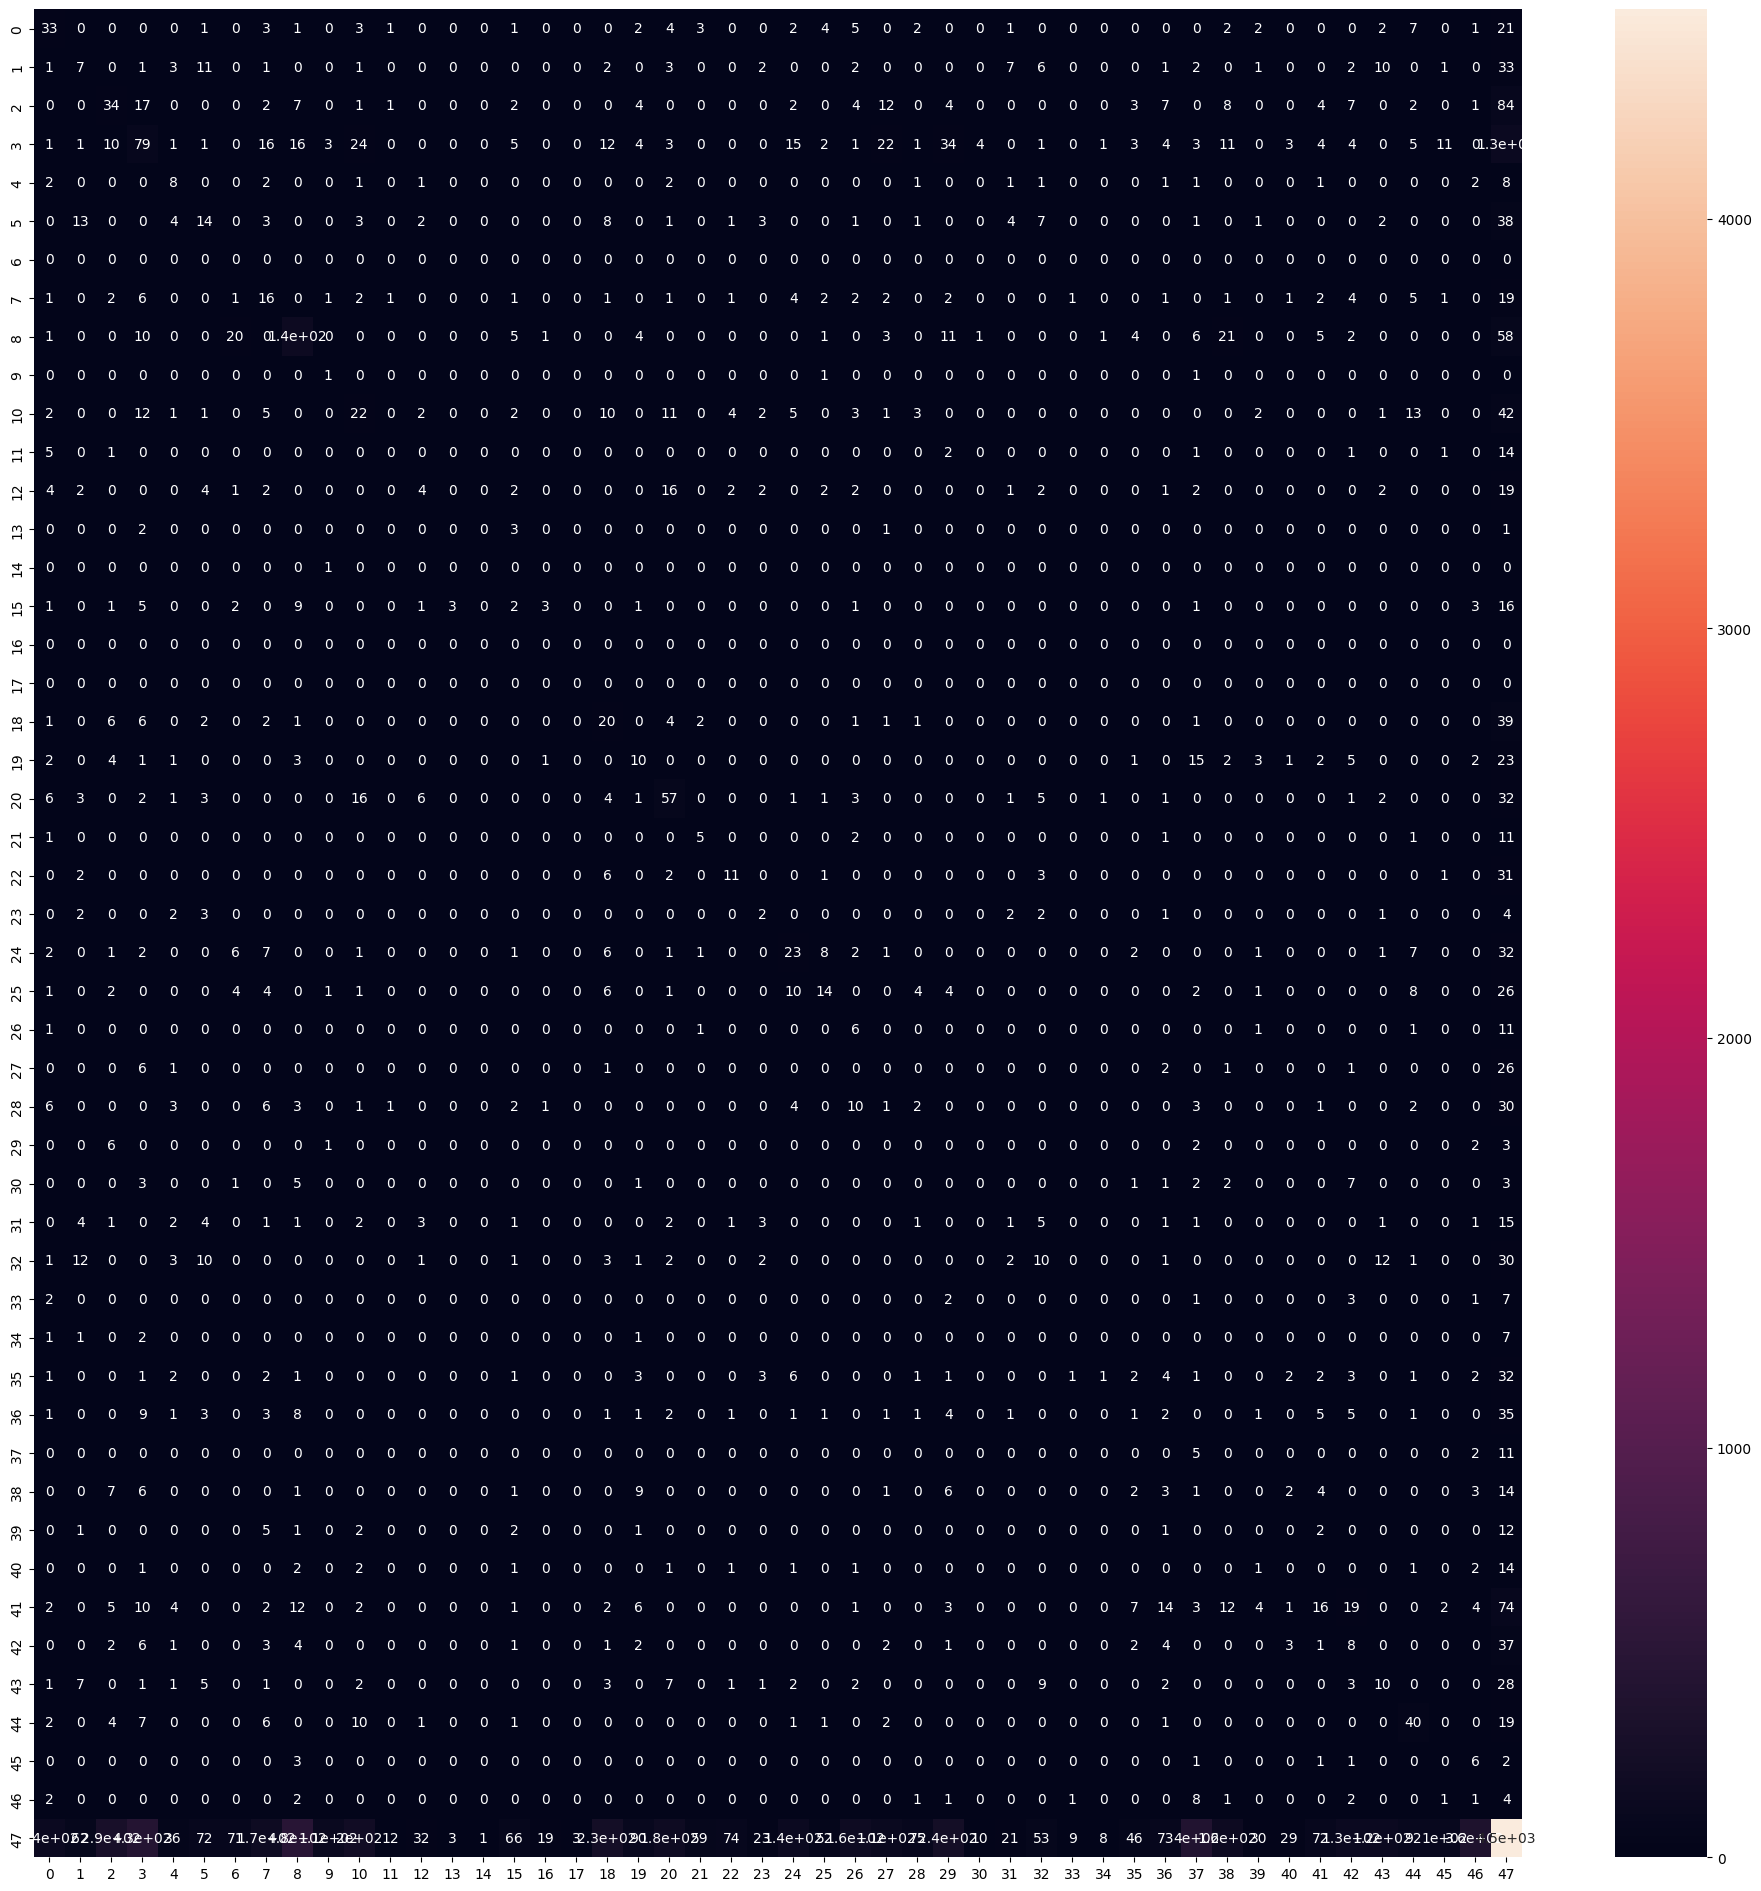

In [ ]:
yhat = np.argmax(model.predict(X_valid), axis=1)

cm = confusion_matrix(y_valid, yhat)

plt.figure(figsize=(24, 24))
ax = sns.heatmap(cm, annot=True)
plt.show()

In [ ]:
cr = classification_report(yhat, y_valid)
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.15      0.21       220
           1       0.07      0.06      0.07       117
           2       0.17      0.09      0.12       380
           3       0.18      0.13      0.15       628
           4       0.25      0.11      0.15        75
           5       0.13      0.10      0.12       134
           6       0.00      0.00      0.00       106
           7       0.20      0.06      0.09       266
           8       0.48      0.21      0.29       701
           9       0.33      0.01      0.02       116
          10       0.15      0.07      0.10       298
          11       0.00      0.00      0.00        16
          12       0.06      0.08      0.07        53
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         1
          15       0.04      0.02      0.03       102
          16       0.00      0.00      0.00        25
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
